# D. Modelling<a id = 'C_Pre-processing'></a>

# Objective<a id = '2_Objective'></a>

- Create a predictive model for rentals data

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.feature_selection import SelectKBest, f_regression,SelectPercentile
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import sklearn.metrics
import eli5
import pickle
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from bayes_opt import BayesianOptimization
import datetime

# Load Data

In [2]:
# Specifiy filepath
filepath = '../data/interim/'

In [3]:
# Load feature and target data
X_scaled = pickle.load(open(filepath + 'X_scaled.pkl', 'rb'))
y = pickle.load(open(filepath + 'y.pkl', 'rb'))
X_features = pickle.load(open(filepath + 'X_features_base.pkl', 'rb'))
X_train = pickle.load(open(filepath + 'X_train_base.pkl', 'rb'))
y_train = pickle.load(open(filepath + 'y_train_base.pkl', 'rb'))
X_test = pickle.load(open(filepath + 'X_test_base.pkl', 'rb'))
y_test = pickle.load(open(filepath + 'y_test_base.pkl', 'rb'))
lm = pickle.load(open(filepath + 'lm_base.pkl', 'rb'))

In [4]:
#View dataframe
pd.DataFrame(X_train, columns = X_features).head()

,serviceCharge,livingSpace,noRooms,gdp_per_capita_2018,hdi_2018,medianLivingSpace_state,medianServiceCharge_state,medianThermalChar_state,medianHeatingCosts_state,medianPictureCount_state,...,typeOfFlat_ground_floor,typeOfFlat_half_basement,typeOfFlat_loft,typeOfFlat_maisonette,typeOfFlat_other,typeOfFlat_penthouse,typeOfFlat_raised_ground_floor,typeOfFlat_roof_storey,typeOfFlat_terraced_flat,typeOfFlat_unknown
0,1.546421,2.645811,2.036228,6.485613,69.424439,10.613782,6.792155,8.610623,15.127208,12.929197,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2.916435
1,1.467407,1.680868,2.036228,4.221426,68.178171,8.518956,5.136567,8.706491,12.290856,11.636278,...,3.106839,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,2.257549,3.890898,3.563400,6.485613,69.424439,10.613782,6.792155,8.610623,15.127208,12.929197,...,0.000000,0.0,0.0,0.0,5.418265,0.0,0.0,0.000000,0.0,0.000000
3,1.295269,2.387455,3.054343,5.156896,67.591692,10.144541,5.688430,10.719703,14.181757,10.343358,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,2.979074,0.0,0.000000
4,1.072336,1.214583,1.018114,6.485613,69.424439,10.613782,6.792155,8.610623,15.127208,12.929197,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,2.979074,0.0,0.000000


In [5]:
#View base rent
pd.DataFrame(y).head()

,baseRent
0,595.00
1,579.00
2,569.00
3,1398.60
4,725.62


In [6]:
len(X_features)

73

# Modelling

## Base Model  - Linear Regression

In [7]:
#Determine predictions for train and the test set
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [8]:
#Review performance of model
r2_score(y_train, y_train_pred), mean_absolute_error(y_train, y_train_pred)

(0.735007318521693, 147.1256859213482)

In [9]:
#Review performance of model
r2_score(y_test, y_test_pred), mean_absolute_error(y_test, y_test_pred)

(0.7285429457365407, 147.26695580709028)

From our pre-processing notebook, we have to improve on this performance if we can. As noted, we will trial the following:
- Choosing select features
- Using other modelling algorithms
- Tuning hyperparameters

# Performance Assessment

We will use the r-squared score to assess different models produced by each algorithm. We will then use the mean absolute error to chose the best algorithm / model combination.

We will use 10-fold cross-validation to assess each model. 

We will trial two linear models and three tree-induction models. Our linear models include lasso and ridge regression. Our tree induction models are decision tree, random forest and XGBoost. 

In [10]:
#Define functions to assess cross-validated performance of learner
def cv_performance(model, X_train, y_train, n_folds = 4):
    cv_scores = cross_validate(model, X_train, y_train.values.ravel(), cv = n_folds, \
                              scoring = ['r2','neg_mean_absolute_error'])
    r2_scores = cv_scores['test_r2']
    mae_scores = cv_scores['test_neg_mean_absolute_error'] * -1                                        
    return r2_scores, mae_scores

def cv_mean_std(cv_scores):
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    return cv_mean, cv_std

def limits(mean, std):
    upper = mean + std
    lower = mean -std
    return lower, upper

#Define function to assess test set performance
def test_performance(model):
    y_pred = model.predict(X_test)
    r2_test_score = r2_score(y_test, y_pred)
    mae_test_score = mean_absolute_error(y_test, y_pred)
    return r2_test_score, mae_test_score

# Linear Modelling

we will use the lasso and ridge regression algorithms to come up with a model.

## Lasso

In [11]:
#Instantiate lasso model
lasso = Lasso()

In [12]:
#Determine cross validation performance on lasso model with 5 folds
lasso_r2_scores, lasso_mae_scores = cv_performance(lasso, X_train, y_train, 5)

In [13]:
#Check r2 cross validation scores
lasso_r2_scores

array([0.76139904, 0.67038378, 0.724201  , 0.75742846, 0.77098693])

In [14]:
#Check mean and standard deviation of r2 cross validation scores
lasso_r2_mean, lasso_r2_std = cv_mean_std(lasso_r2_scores)
lasso_r2_mean, lasso_r2_std

(0.736879842220721, 0.036794592864321185)

In [15]:
#Lasso model r2 lower and upper limits
limits(lasso_r2_mean, lasso_r2_std)

(0.7000852493563998, 0.7736744350850422)

In [16]:
#Fit lasso model to data
lasso.fit(X_train, y_train);

In [17]:
#Determine performance of lasso model on test set
lasso_r2_test_score, lasso_mae_test_score = test_performance(lasso)

In [18]:
#Check r2 performance on lasso on test set
lasso_r2_test_score

0.7282111064368844

We note that our test score for lasso falls within the standard deviation of our cross validation score. This suggests that our model is not overfitting and is appropriate for the data.

### Feature importance - Lasso

In [19]:
#Review coefficients of the 73 features
lasso.coef_

array([ 8.21227791e+01,  2.65480554e+02, -3.02378814e+01,  5.11986477e+00,
        0.00000000e+00,  2.75971522e+01,  0.00000000e+00, -0.00000000e+00,
        5.90267604e+01,  0.00000000e+00, -3.26724394e+00, -9.98220560e+01,
        1.01258845e+02, -3.53188792e+01,  1.83875209e+01, -2.20684140e-01,
       -1.65291234e+01,  3.80476699e+00,  1.46088235e+01, -6.73647574e+00,
        0.00000000e+00,  5.61676530e+01,  4.63543087e+00,  1.05164326e+01,
        2.73264467e+01, -3.87139231e+00, -1.72380925e+00,  5.15584012e+00,
       -2.61699062e+01, -0.00000000e+00, -3.19304788e+00, -0.00000000e+00,
        0.00000000e+00, -2.37793888e+00, -3.08836073e+01,  0.00000000e+00,
        8.13850387e-01,  0.00000000e+00, -1.78412394e+01,  0.00000000e+00,
        2.15377945e-01, -0.00000000e+00, -2.63299910e+01,  5.43670549e-15,
        1.77732334e+01,  7.65442768e+00, -3.32685027e+00,  1.17013955e+01,
       -4.78914259e+00, -3.82858863e+00, -1.46268206e+00, -0.00000000e+00,
        0.00000000e+00,  

We note that some of the coefficients are zero, which is one great feature of the lasso algorithm.

In [20]:
#Create lasso coefficent data frame
lasso_coeff_df = pd.DataFrame(lasso.coef_, index = X_features, columns = ['coefficient']).\
sort_values(by = 'coefficient').reset_index().rename(columns = {'index': 'feature'})
lasso_coeff_df.head()

,feature,coefficient
0,medianLivingSpace_ct,-99.822056
1,medianThermalChar_ct,-35.318879
2,state_Sachsen,-30.883607
3,noRooms,-30.237881
4,hasKitchen_No,-26.329991


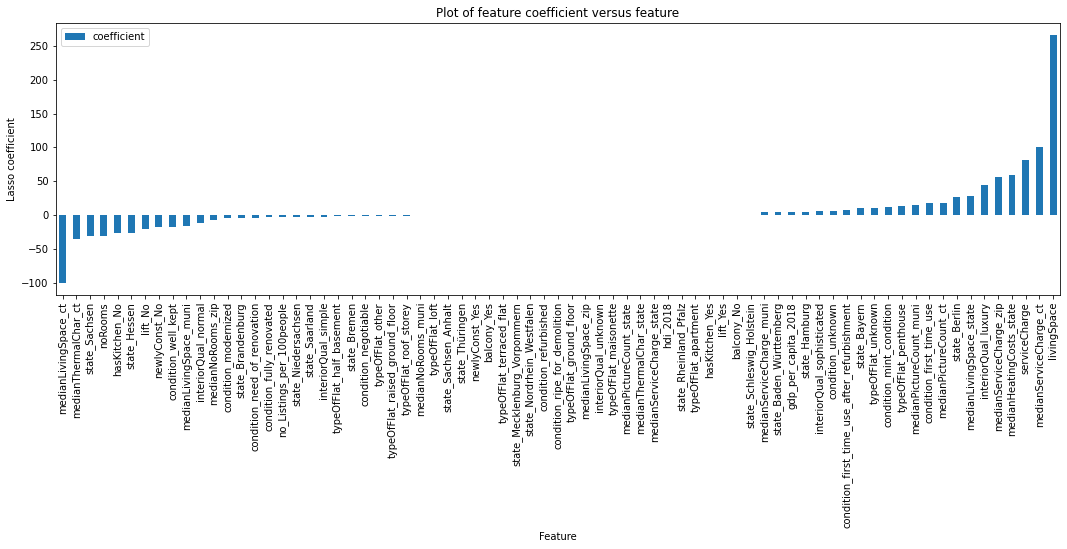

In [21]:
#View plot of features and their significance
lasso_coeff_df.plot.bar(x = 'feature', y = 'coefficient', figsize = (18, 5))
plt.title('Plot of feature coefficient versus feature')
plt.xlabel('Feature')
plt.ylabel('Lasso coefficient');

We observe that the living area and the service charge are the two most important features that positively contribute to base rent. Suprisingly, the median living area for the city or town is a drag on the base rent for individual properties, suggesting that the higher the median living area in the city / town available for rent, the lower the rent for an individual property. Perhaps, city / towns that offer larger living areas. 

In [22]:
#Create dataframe of the top 20 features
lasso_feature_importance = lasso_coeff_df.set_index('feature')
lasso_feature_importance['coefficient_magnitude'] = abs(lasso_feature_importance.coefficient)
lasso_top20_features = lasso_feature_importance.sort_values(by = 'coefficient_magnitude', ascending = False)[:20]


In [23]:
#View the top 20 features
lasso_top20_features

,coefficient,coefficient_magnitude
feature,,
livingSpace,265.480554,265.480554
medianServiceCharge_ct,101.258845,101.258845
medianLivingSpace_ct,-99.822056,99.822056
serviceCharge,82.122779,82.122779
medianHeatingCosts_state,59.026760,59.026760
medianServiceCharge_zip,56.167653,56.167653
interiorQual_luxury,44.162372,44.162372
medianThermalChar_ct,-35.318879,35.318879
state_Sachsen,-30.883607,30.883607


We notice that some of the features that contribute to the base rent are ones that a landlord cannot influence. These include the median service charge for the city / town and the median living area. The features that landlords can influence according to the lasso model are as follows:
- livingSpace: Landlords can set higher base rents for properties with a larger area. 
- interiorQuality: Properties that are considered to be luxurious will elicity higher base rent. Landlords should consider rennovating their properties. 
- hasKitchen: Landlords should install a kitchen if one is absent. The absence of a kitchen reduces base rent. 
- condition_first_time_use: New properties command higher rent

# Ridge

In [24]:
#Instantiate ridge model
ridge = Ridge();

In [25]:
#Determine cross validation performance on ridge model with 5 folds
ridge_r2_scores, ridge_mae_scores = cv_performance(ridge, X_train, y_train, 5)

In [26]:
#Check r2 cross validation scores
ridge_r2_scores

array([0.7612815 , 0.67111133, 0.72440346, 0.75757941, 0.77104556])

In [27]:
#Check mean and standard deviation of r2 cross validation scores
ridge_r2_mean, ridge_r2_std = cv_mean_std(ridge_r2_scores)
ridge_r2_mean, ridge_r2_std

(0.7370842525996383, 0.036529870855028096)

In [28]:
#Ridge model r2 lower and upper limits
limits(ridge_r2_mean, ridge_r2_std)

(0.7005543817446102, 0.7736141234546664)

In [29]:
#Fit ridge model to data
ridge.fit(X_train, y_train);

In [30]:
#Determine performance of ridge model on test set
ridge_r2_test_score, ridge_mae_test_score = test_performance(ridge)

In [31]:
#Check r2 performance on ridge on test set
ridge_r2_test_score

0.728541451338594

We get a similar performance for the test set with the ridge model as with the lasso model. The r2 score also falls within the standard deviation of the cross validation values, suggesting a representative model. 

### Feature importance - ridge

In [32]:
#Review coefficients of the 73 features
ridge.coef_

array([  81.55985148,  270.79133086,  -34.64244378,   15.21263667,
          6.06797309,   17.15351939,    7.6559147 ,   -0.82884454,
         25.79722809,    3.21851997,  -26.55127728, -109.89351909,
        105.60675836,  -37.62401332,   18.50070285,    2.41758679,
        -25.20262213,    8.8570319 ,   15.07034052,   -9.12884205,
          9.08959807,   50.28420507,    9.59840677,   18.67485192,
         28.03405143,   -3.52776382,   -3.71419357,    4.1924492 ,
        -19.71575021,    2.57035589,    5.39770737,   -2.41039067,
          3.04875141,   -2.61039803,  -28.18770777,   11.02911225,
         10.74125723,   -7.99844468,   -9.01972935,    9.01972939,
          0.96545833,   -0.96545846,  -13.27780282,   13.27780286,
         17.67269314,    7.73346385,   -5.07788314,   11.49539966,
         -6.52985478,   -4.88900823,   -2.63697667,   -1.06986083,
          0.34588622,    5.49435597,  -18.91019453,   43.30045545,
        -14.11954071,   -3.66697761,    3.532753  ,   -3.83354

Unlike lasso, the ridge reduces the coefficients of useless features to a very low value, but not to zero.

In [33]:
#Create ridge coefficent data frame
ridge_coeff_df = pd.DataFrame(ridge.coef_, index = X_features, columns = ['coefficient']).\
sort_values(by = 'coefficient').reset_index().rename(columns = {'index': 'feature'})
ridge_coeff_df.head()

,feature,coefficient
0,medianLivingSpace_ct,-109.893519
1,medianThermalChar_ct,-37.624013
2,noRooms,-34.642444
3,state_Sachsen,-28.187708
4,no_Listings_per_100people,-26.551277


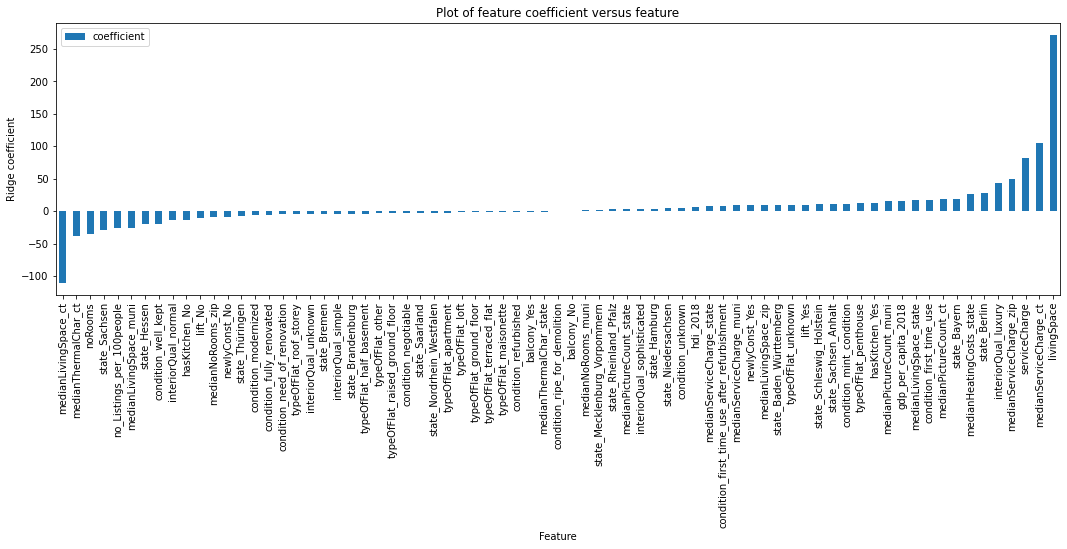

In [34]:
#View plot of features and their significance
ridge_coeff_df.plot.bar(x = 'feature', y = 'coefficient', figsize = (18, 5))
plt.title('Plot of feature coefficient versus feature')
plt.xlabel('Feature')
plt.ylabel('Ridge coefficient');

Here again, we notice that the living and service charge positively influence the base rent, while the median living area of the city and median thermal characterisitics of the city reduces base rent. 

In [35]:
#Create dataframe of the top 20 features
ridge_feature_importance = ridge_coeff_df.set_index('feature')
ridge_feature_importance['coefficient_magnitude'] = abs(ridge_feature_importance.coefficient)
ridge_top20_features = ridge_feature_importance.sort_values(by = 'coefficient_magnitude', ascending = False)[:20]

In [36]:
#View the top 20 features
ridge_top20_features

,coefficient,coefficient_magnitude
feature,,
livingSpace,270.791331,270.791331
medianLivingSpace_ct,-109.893519,109.893519
medianServiceCharge_ct,105.606758,105.606758
serviceCharge,81.559851,81.559851
medianServiceCharge_zip,50.284205,50.284205
interiorQual_luxury,43.300455,43.300455
medianThermalChar_ct,-37.624013,37.624013
noRooms,-34.642444,34.642444
state_Sachsen,-28.187708,28.187708


We note that the ridge model has similar top 20 features as the lasso model, althought these are not the same.

### Feature importance comparison 

In [37]:
common_features_ridge_lasso = list(set(ridge_top20_features.index).intersection(set(lasso_top20_features.index)))
common_features_ridge_lasso

['serviceCharge',
 'medianServiceCharge_ct',
 'state_Hessen',
 'condition_well_kept',
 'medianHeatingCosts_state',
 'noRooms',
 'condition_first_time_use',
 'medianLivingSpace_state',
 'medianLivingSpace_ct',
 'state_Berlin',
 'interiorQual_luxury',
 'livingSpace',
 'medianLivingSpace_muni',
 'state_Sachsen',
 'medianServiceCharge_zip',
 'medianThermalChar_ct',
 'medianPictureCount_ct']

In [38]:
len(common_features_ridge_lasso)

17

Of the 20 top features determined by both models, 17 of them are featured in both, suggesting that both models are interpreting the data in a similar manner.

In [39]:
diff_features_ridge_lasso = list(set(ridge_top20_features.index).difference(set(lasso_top20_features.index))) + list(set(lasso_top20_features.index).difference(set(ridge_top20_features.index)))

In [40]:
diff_features_ridge_lasso

['state_Bayern',
 'no_Listings_per_100people',
 'gdp_per_capita_2018',
 'hasKitchen_No',
 'newlyConst_No',
 'lift_No']

The six features that are featured in one, but not both models include no_Listings_per_100people, gdp_per_capita_2018, state_Bayern, lift_No, newlyConst_No, hasKitchen_No, and none of these feature in the top 10.

# Tree induction ensemble models

The linear models we developed were appropriate; however,  tree induction ensemble models may provide better performance because they are not constrained by limitations of a model. For instance, outliers are unlikely to affect tree induction models. We will trial a random forest model and an XGBoost model to determine if we can improve performance.

## Random forest

In [41]:
#Instantiate random forest model
rf = RandomForestRegressor(n_estimators = 10, max_depth = 15, random_state = 77)

In [42]:
#Determine cross validation performance on random forest model with 5 folds
rf_r2_scores, rf_mae_scores = cv_performance(rf, X_train, y_train, 5)

In [43]:
#Check r2 cross validation scores
rf_r2_scores

array([0.85717382, 0.75774106, 0.83146012, 0.86731928, 0.83374287])

We observe that our cross-validation r2-scores for the random forest model are better than the ones obtained from our linear models. 

In [44]:
#Check mean and standard deviation of r2 cross validation scores
rf_r2_mean, rf_r2_std = cv_mean_std(rf_r2_scores)
rf_r2_mean, rf_r2_std

(0.8294874308391587, 0.03838574383963326)

In [45]:
#Random forest model r2 lower and upper limits
limits(rf_r2_mean, rf_r2_std)

(0.7911016869995254, 0.8678731746787919)

In [46]:
#Fit random forest model to data
rf.fit(X_train, y_train);

In [47]:
#Determine performance of random forest model on test set
rf_r2_test_score, rf_mae_test_score = test_performance(rf)

In [48]:
#Check r2 performance on random forest on test set
rf_r2_test_score

0.8188367291712011

Our test score falls within the range of the model's standard deviation for the cross-validation scores. Our random forest model is our best model so far.

### Hyperparameter tuning of random forest model

We can check if we can improve the performance of our random forest model, while being cautious of overfitting the model with a cross validation random search on the number of trees to use and their max depth.

In [49]:
#Instantiate random forest estimator for grid search
rf_grid = RandomForestRegressor()

In [50]:
#Create hyperparameter grid
n_est = np.arange(10, 30, 5)
max_depth = max_depth = np.arange(5, 30, 5)
grid_params = {'n_estimators': n_est, 'max_depth': max_depth}

In [51]:
#Perform cross validated randomized search on the parameter grid
rf_grid_cv = RandomizedSearchCV(rf_grid, param_distributions = grid_params, n_iter = 2, scoring = 'r2', cv= 5, random_state = 77)

In [52]:
#Fit randomized search model to data
rf_grid_cv.fit(X_train, y_train);

In [53]:
rf_grid_cv.best_params_

{'n_estimators': 20, 'max_depth': 20}

We observe that best parameters are 20 estimators and a max depth of 20, which is a change from the previous number of estimators we had. Let us determine if the performance has improved.

In [54]:
#Instantiate random forest model with updated parameters
rf_search = RandomForestRegressor(n_estimators = 20, max_depth = 20, random_state = 77)

In [55]:
#Determine cross validation performance on updated random forest model with 5 folds
rf_search_r2_scores, rf_search_mae_scores = cv_performance(rf_search, X_train, y_train, 5)

In [56]:
#Check updated r2 cross validation scores
rf_search_r2_scores

array([0.86559696, 0.76356628, 0.83612583, 0.88308455, 0.85133525])

In [57]:
#Check updated mean and standard deviation of r2 cross validation scores
rf_search_r2_mean, rf_search_r2_std = cv_mean_std(rf_search_r2_scores)
rf_search_r2_mean, rf_search_r2_std

(0.8399417744721205, 0.04122396803568293)

In [58]:
#Updated random forest model r2 lower and upper limits
limits(rf_search_r2_mean, rf_search_r2_std)

(0.7987178064364375, 0.8811657425078034)

In [59]:
#Fit updated random forest model to data
rf_search.fit(X_train, y_train);

In [60]:
#Determine updated performance of random forest model on test set
rf_search_r2_test_score, rf_search_mae_test_score = test_performance(rf_search)

In [61]:
#Check updated r2 performance on random forest on test set
rf_search_r2_test_score

0.829282811437949

We observe slightly better performance with the current parameters than the previous parameters.

### Feature importance - random forest

In [62]:
#Get feature importance for random forest
rf_search.feature_importances_

array([1.48469475e-01, 4.47747583e-01, 6.14521285e-03, 3.36969324e-03,
       2.98360126e-03, 1.25747445e-03, 1.43524614e-03, 1.70097212e-03,
       2.29759144e-03, 1.38794597e-03, 9.25597032e-03, 4.08537063e-02,
       1.60515538e-01, 9.21531131e-03, 1.01935136e-02, 2.04071790e-03,
       1.62505119e-02, 1.10460595e-02, 9.05028127e-03, 2.32809672e-03,
       1.03266444e-02, 2.04004678e-02, 3.22854511e-04, 2.71216829e-03,
       4.68956909e-04, 6.24069839e-05, 2.44536155e-05, 6.79043213e-05,
       4.93531946e-04, 2.11440591e-05, 2.37445498e-04, 1.69835863e-04,
       1.54675253e-04, 5.82516059e-06, 1.48472034e-03, 1.10056560e-05,
       1.51730260e-04, 2.53838057e-05, 3.09226631e-03, 4.10306980e-03,
       1.03529093e-03, 8.70422772e-04, 2.20836183e-03, 3.29464550e-03,
       6.55795313e-03, 1.15829952e-03, 6.89658466e-04, 5.27147312e-03,
       5.71406274e-04, 2.94134645e-05, 6.64532636e-05, 1.02056743e-03,
       2.88898852e-08, 2.50021444e-03, 1.96747578e-03, 6.50112467e-03,
      

In [63]:
#Create random forest coefficent data frame
rf_search_coeff_df = pd.DataFrame(rf_search.feature_importances_, index = X_features, columns = ['coefficient']).\
sort_values(by = 'coefficient').reset_index().rename(columns = {'index': 'feature'})
rf_search_coeff_df.head()

,feature,coefficient
0,condition_ripe_for_demolition,2.888989e-08
1,state_Saarland,5.825161e-06
2,state_Sachsen_Anhalt,1.100566e-05
3,state_Mecklenburg_Vorpommern,2.114406e-05
4,state_Bremen,2.445362e-05


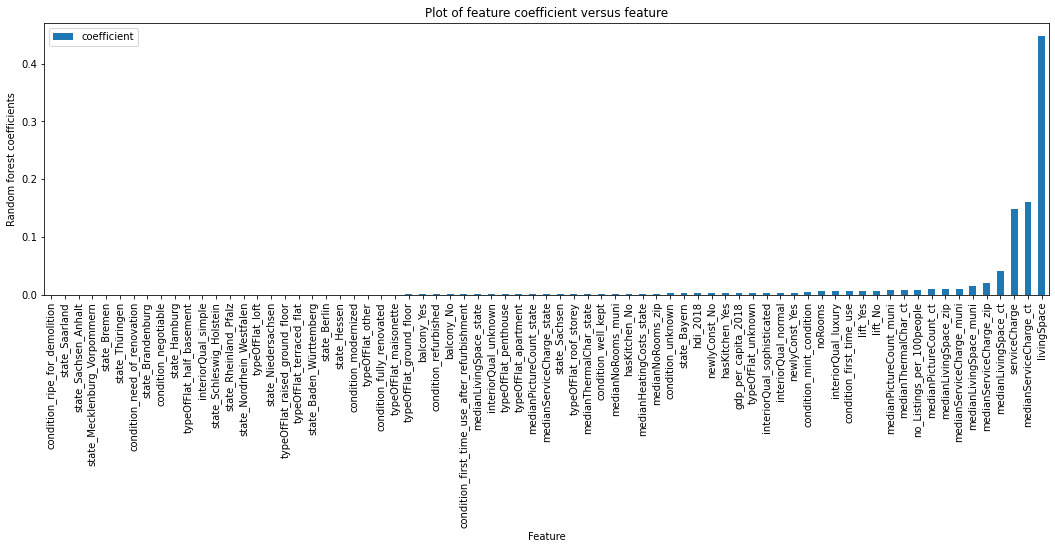

In [64]:
#View plot of features and their significance
rf_search_coeff_df.plot.bar(x = 'feature', y = 'coefficient', figsize = (18, 5))
plt.title('Plot of feature coefficient versus feature')
plt.xlabel('Feature')
plt.ylabel('Random forest coefficients');

In [65]:
#Create dataframe of the top 20 features
rf_search_feature_importance = rf_search_coeff_df.set_index('feature')
rf_search_top20_features = rf_search_coeff_df.sort_values(by = 'coefficient', ascending = False)[:20]

In [66]:
#View the top 20 features
rf_search_top20_features

,feature,coefficient
72,livingSpace,0.447748
71,medianServiceCharge_ct,0.160516
70,serviceCharge,0.148469
69,medianLivingSpace_ct,0.040854
68,medianServiceCharge_zip,0.020400
67,medianLivingSpace_muni,0.016251
66,medianServiceCharge_muni,0.011046
65,medianLivingSpace_zip,0.010327
64,medianPictureCount_ct,0.010194
63,no_Listings_per_100people,0.009256


### Feature importance comparison - random forest / lasso

In [67]:
#Get common features between lasso and random forest model
common_features_rf_search_lasso = list(set(rf_search_top20_features.feature).intersection(set(lasso_top20_features.index)))
common_features_rf_search_lasso

['serviceCharge',
 'medianServiceCharge_ct',
 'noRooms',
 'condition_first_time_use',
 'medianLivingSpace_ct',
 'lift_No',
 'interiorQual_luxury',
 'livingSpace',
 'medianLivingSpace_muni',
 'medianServiceCharge_zip',
 'medianThermalChar_ct',
 'medianPictureCount_ct']

In [68]:
#Get count of features common to lasso and random forest
len(common_features_rf_search_lasso)

12

We observe that 12 of the top features of the lasso model were found in the random forest model. 

In [69]:
#Get features that were different between the random forest and lasso model
diff_features_rf_search_lasso  = list(set(rf_search_top20_features.feature).difference(set(lasso_top20_features.index))) 

In [70]:
#Check the different features
diff_features_rf_search_lasso

['medianPictureCount_muni',
 'interiorQual_normal',
 'medianLivingSpace_zip',
 'newlyConst_Yes',
 'condition_mint_condition',
 'medianServiceCharge_muni',
 'no_Listings_per_100people',
 'lift_Yes']

We note that of the seven features that were not picked up in the lasso's top 20 features list by the random forest model, the medianServiceCharge_muni and medianLivingSpace_zip were in the top ten. The different selection of features may account by the better performance of the random forest model. 

## XGBoost

In [71]:
#Instantiate XGBoost learner
xg = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 77)

In [72]:
#Determine cross validation performance on random forest model with 5 folds
xg_r2_scores, xg_mae_scores = cv_performance(xg, X_train, y_train, 5)

In [73]:
#Check r2 cross validation scores
xg_r2_scores

array([0.87730438, 0.77207787, 0.85208803, 0.88835724, 0.86347631])

In [74]:
#Check mean and standard deviation of r2 cross validation scores
xg_r2_mean, xg_r2_std = cv_mean_std(xg_r2_scores)
xg_r2_mean, xg_r2_std

(0.8506607675602798, 0.04116418885752121)

In [75]:
#Random forest model r2 lower and upper limits
limits(xg_r2_mean, xg_r2_std)

(0.8094965787027586, 0.8918249564178009)

In [76]:
#Fit random forest model to data
xg.fit(X_train, y_train);

In [77]:
#Determine performance of random forest model on test set
xg_r2_test_score, xg_mae_test_score = test_performance(xg)

In [78]:
#Check r2 performance on random forest on test set
xg_r2_test_score

0.8348090854298527

The XGBoost model seems to give us the best performance on the test set amongst all the models.

### Hyperparameter tuning for  XGBoost

In [79]:
#Instatiate XGBoost grid search model
xg_grid = xgb.XGBRegressor(objective = 'reg:squarederror')

In [80]:
#Set up search grid for XGBoost parameters
xg_params = {'subsample': np.arange(0.1, 1, 0.1), 
                 'max_depth':np.arange(3, 5, 1),
                 'colsample_bytree': np.arange(0.1, 1, 0.1)}

In [81]:
#Set up randomized search with the xg boost learner over the search grid
search_xg = RandomizedSearchCV(estimator = xg_grid, param_distributions = xg_params, n_iter = 5, \
                            scoring = 'r2', cv = 4, random_state = 77)

In [82]:
#Fit xg boost learner with search grid to data
search_xg.fit(X_train, y_train.values.ravel());

In [83]:
#Check xg boost learner's best parameters
search_xg.best_params_

{'subsample': 0.7000000000000001, 'max_depth': 4, 'colsample_bytree': 0.2}

Our optimal parameters require that we subsample 70% of the observations, subsample 2% of the features and go to a maximum tree depth 4. 

In [84]:
xg_search = xgb.XGBRegressor(subsample = 0.7, max_depth = 4, colsample_bytree = 0.2, objective = 'reg:squarederror')

In [85]:
#Determine cross validation performance on updated random forest model with 5 folds
xg_search_r2_scores, xg_search_mae_scores = cv_performance(xg_search, X_train, y_train, 5)

In [86]:
#Check updated r2 cross validation scores
xg_search_r2_scores

array([0.86444086, 0.75592361, 0.83021036, 0.86959132, 0.8595596 ])

In [87]:
#Check updated mean and standard deviation of r2 cross validation scores
xg_search_r2_mean, xg_search_r2_std = cv_mean_std(xg_search_r2_scores)
xg_search_r2_mean, xg_search_r2_std

(0.8359451514521605, 0.04228013008948254)

In [88]:
#Updated random forest model r2 lower and upper limits
limits(xg_search_r2_mean, xg_search_r2_std)

(0.793665021362678, 0.878225281541643)

In [89]:
#Fit updated random forest model to data
xg_search.fit(X_train, y_train);

In [90]:
#Determine updated performance of random forest model on test set
xg_search_r2_test_score, xg_search_mae_test_score = test_performance(xg_search)

In [91]:
#Check updated r2 performance on random forest on test set
xg_search_r2_test_score

0.8203339059565137

We observe that tuning hyperparameters did not improve our XGBoost model.

### Feature importance - XGBoost

In [92]:
#Get feature importance for XGBoost model
xg.feature_importances_

array([0.04585626, 0.11247151, 0.00310476, 0.01235552, 0.00836174,
       0.00572546, 0.00372195, 0.00377418, 0.1168148 , 0.00478888,
       0.01489788, 0.03334   , 0.12126505, 0.00624577, 0.02602532,
       0.00406396, 0.0113605 , 0.00633636, 0.00602473, 0.00728827,
       0.00539275, 0.02409717, 0.        , 0.05735881, 0.01364255,
       0.00271916, 0.00118812, 0.        , 0.        , 0.        ,
       0.00468419, 0.        , 0.00169103, 0.        , 0.        ,
       0.        , 0.00305653, 0.        , 0.03053292, 0.        ,
       0.0055649 , 0.        , 0.0131475 , 0.        , 0.02778919,
       0.00677158, 0.00466842, 0.0480022 , 0.00187472, 0.00323989,
       0.00108641, 0.0012967 , 0.        , 0.00338693, 0.01566215,
       0.04527647, 0.01984011, 0.00567393, 0.02295457, 0.00302571,
       0.03680725, 0.        , 0.00129065, 0.00081413, 0.00123758,
       0.00126631, 0.00182189, 0.00111807, 0.00735197, 0.00018819,
       0.01145712, 0.00079218, 0.00840712], dtype=float32)

In [93]:
#Create XGBoost coefficent data frame
xg_coeff_df = pd.DataFrame(xg.feature_importances_, index = X_features, columns = ['coefficient']).\
sort_values(by = 'coefficient').reset_index().rename(columns = {'index': 'feature'})
xg_coeff_df.head()

,feature,coefficient
0,state_Nordrhein_Westfalen,0.0
1,state_Hessen,0.0
2,state_Hamburg,0.0
3,state_Baden_Württemberg,0.0
4,hasKitchen_Yes,0.0


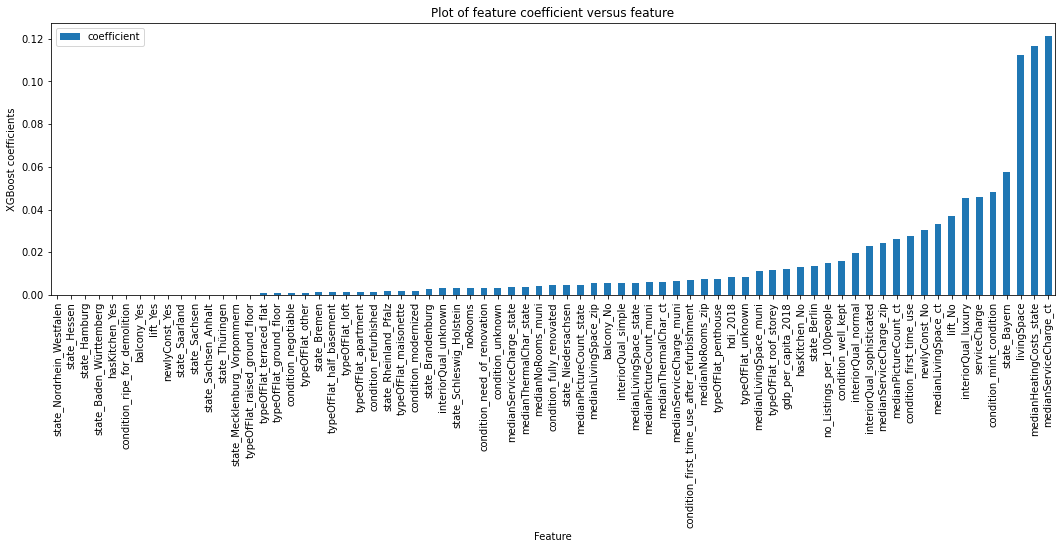

In [94]:
#View plot of features and their significance
xg_coeff_df.plot.bar(x = 'feature', y = 'coefficient', figsize = (18, 5))
plt.title('Plot of feature coefficient versus feature')
plt.xlabel('Feature')
plt.ylabel('XGBoost coefficients');

In [95]:
#Create dataframe of the top 20 features
xg_feature_importance = xg_coeff_df.set_index('feature')
xg_top20_features = xg_coeff_df.sort_values(by = 'coefficient', ascending = False)[:20]

In [96]:
#View the top 20 features
xg_top20_features

,feature,coefficient
72,medianServiceCharge_ct,0.121265
71,medianHeatingCosts_state,0.116815
70,livingSpace,0.112472
69,state_Bayern,0.057359
68,condition_mint_condition,0.048002
67,serviceCharge,0.045856
66,interiorQual_luxury,0.045276
65,lift_No,0.036807
64,medianLivingSpace_ct,0.033340
63,newlyConst_No,0.030533


### Feature importance comparison - XGBoost / lasso & random forest

In [97]:
#Get common features between lasso and XGBoost model
common_features_xg_lasso = list(set(xg_top20_features.feature).intersection(set(lasso_top20_features.index)))
common_features_xg_lasso

['serviceCharge',
 'medianServiceCharge_ct',
 'hasKitchen_No',
 'medianHeatingCosts_state',
 'condition_well_kept',
 'condition_first_time_use',
 'medianLivingSpace_ct',
 'lift_No',
 'state_Berlin',
 'interiorQual_luxury',
 'livingSpace',
 'newlyConst_No',
 'medianServiceCharge_zip',
 'medianPictureCount_ct']

In [98]:
#Count of common features
len(common_features_xg_lasso)

14

We note that the XGBoost and lasso models share 14 of the top 20 features.

In [99]:
#Get common features between random forest and XGBoost model
common_features_xg_rf_search = list(set(xg_top20_features.feature).intersection(set(rf_search_top20_features.feature)))
common_features_xg_rf_search

['serviceCharge',
 'medianServiceCharge_ct',
 'condition_first_time_use',
 'medianLivingSpace_ct',
 'lift_No',
 'interiorQual_luxury',
 'livingSpace',
 'interiorQual_normal',
 'medianServiceCharge_zip',
 'no_Listings_per_100people',
 'condition_mint_condition',
 'medianPictureCount_ct']

In [100]:
#Count of common features
len(common_features_xg_rf_search)

12

We note that XGBoost and random forest model only share 11 of the top 20 features. We would have expected them to share more features since they both employ tree-induction for creating models.

In [101]:
#Get features that were different between the XGBoost and lasso model
diff_features_xg_lasso  = list(set(xg_top20_features.feature).difference(set(lasso_top20_features.index))) 

In [102]:
#Check the different features
diff_features_xg_lasso

['state_Bayern',
 'interiorQual_normal',
 'interiorQual_sophisticated',
 'condition_mint_condition',
 'no_Listings_per_100people',
 'gdp_per_capita_2018']

In [103]:
#Get features that were different between the random forest and XGBoost 
diff_features_xg_rf_search  = list(set(xg_top20_features.feature).difference(set(rf_search_top20_features.feature))) 

In [104]:
#Check the different features
diff_features_xg_rf_search

['state_Bayern',
 'condition_well_kept',
 'medianHeatingCosts_state',
 'hasKitchen_No',
 'state_Berlin',
 'newlyConst_No',
 'interiorQual_sophisticated',
 'gdp_per_capita_2018']

### Most common features between all models

In [105]:
#Get common features between random forest and XGBoost model
common_features_all = list(set(xg_top20_features.feature).intersection(set(rf_search_top20_features.feature))\
                          .intersection(set(ridge_top20_features.index))\
                          .intersection(set(lasso_top20_features.index)))
common_features_all

['serviceCharge',
 'medianServiceCharge_ct',
 'condition_first_time_use',
 'medianLivingSpace_ct',
 'interiorQual_luxury',
 'livingSpace',
 'medianServiceCharge_zip',
 'medianPictureCount_ct']

For all algorithms, the most important features were
- medianServiceCharge_ct
- medianLivingSpace_ct
- livingSpace
- medianPictureCount_ct
- interiorQual_luxury
- condition_first_time_use
- medianServiceCharge_zip
- serviceCharge

Of these features the landlord has control over the living area, interior quality, service charge and first-time-use. In reality, if a landlord wants to implement a change, only the interior quality can be affected. 

# Choosing a model

## Performance Summary

In [106]:
#Define r2 metrics data frame
trial_models = ['lasso', 'ridge', 'random_forest', 'random_forest_hyper', 'XGBoost', 'XGBoost_hyper']
r2_metrics = ['r2_cv_mean', 'r2_cv_std', 'r2_test_score']
r2_mean = [lasso_r2_mean, ridge_r2_mean, rf_r2_mean, rf_search_r2_mean, xg_r2_mean, xg_search_r2_mean]
r2_std = [lasso_r2_std, ridge_r2_std, rf_r2_std, rf_search_r2_std, xg_r2_std, xg_search_r2_std]
r2_test = [lasso_r2_test_score, ridge_r2_test_score, rf_r2_test_score, rf_search_r2_test_score, \
           xg_r2_test_score, xg_search_r2_test_score]
r2_performance= [r2_mean, r2_std, r2_test]
r2_performance_df = pd.DataFrame(r2_performance, columns = trial_models, index = r2_metrics).T \
                    .sort_values(by = 'r2_test_score', ascending = False)

#Define mae metrics data frame
mae_metrics=['mae_cv_mean', 'mae_cv_std', 'mae_test_score']
mae_mean = [lasso_mae_scores.mean(), ridge_mae_scores.mean(), rf_mae_scores.mean(), rf_search_mae_scores.mean(),\
            xg_mae_scores.mean(), xg_search_mae_scores.mean()]
mae_std = [lasso_mae_scores.std(), ridge_mae_scores.std(), rf_mae_scores.std(), rf_search_mae_scores.std(), \
           xg_mae_scores.std(), xg_search_mae_scores.std()]
mae_test = [lasso_mae_test_score, ridge_mae_test_score, rf_mae_test_score, rf_search_mae_test_score, xg_mae_test_score, \
            xg_search_mae_test_score]
mae_performance= [mae_mean, mae_std, mae_test]
mae_performance_df = pd.DataFrame(mae_performance, columns = trial_models, index = mae_metrics).T \
                    .sort_values(by = 'mae_test_score')

In [107]:
#Check r2 performance
r2_performance_df

,r2_cv_mean,r2_cv_std,r2_test_score
XGBoost,0.850661,0.041164,0.834809
random_forest_hyper,0.839942,0.041224,0.829283
XGBoost_hyper,0.835945,0.042280,0.820334
random_forest,0.829487,0.038386,0.818837
ridge,0.737084,0.036530,0.728541
lasso,0.736880,0.036795,0.728211


In [108]:
#Check mae performance
mae_performance_df

,mae_cv_mean,mae_cv_std,mae_test_score
random_forest_hyper,90.748024,0.935389,89.138054
XGBoost,92.108343,0.693799,92.476135
random_forest,97.172547,0.975654,95.836247
XGBoost_hyper,102.670443,1.127958,103.301763
lasso,146.475853,1.029786,146.548822
ridge,147.222076,0.989770,147.266011


Our best models are the random forest and the XGBoost models. The XGBoost performs better on the r2 measure, while the random forest model performs better on the mean absolute error score.

The linear models (lasso and ridge) have lower standard deviations on the r2 score than the tree induction models. 

We will select the random forest model because it offers the best mean absolute error score and the r2 score is acceptable

# Save Best Model

In [109]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = str(sklearn.__version__)
best_model.X_columns = [col for col in X_features]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '..\models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
rentalsmodel_path = os.path.join(modelpath, 'apartment_pricing_model.pkl')
if not os.path.exists(rentalsmodel_path):
    with open(rentalsmodel_path, 'wb') as f:
        pickle.dump(best_model, f)